In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import csv
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import re
from sklearn import model_selection, naive_bayes, svm

warnings.filterwarnings('ignore')
%matplotlib inline

# Data Analysis & Exploration

In this section, we're working on exploring and visualizing the data to uncover insights from the start.

In [60]:
#seed should be unified with all team members to avoid randomness. 
np.random.seed(500)

In [61]:
#Read CSV file
transactions = pd.read_csv("newtransactions.csv",encoding='latin-1')

In [62]:
#Overview
print(transactions.shape)
print(transactions.size)
transactions.head()

(204, 3)
612


,ï»¿bankname,type,sms
0,AlAhli,Withdrawl,PoS Purchase (Apple Pay)\nAmount 990 SAR\nMada...
1,Sabb,Other,"Dear Customer, Please update your personal inf..."
2,Gulf International bank,Withdrawl,"ATM Withdrawal \nAmount: SAR 2,500.00 \nCard:*..."
3,Gulf International bank,Withdrawl,POS Purchase\nAmount: SAR 85.42\nAt:ALDREES 40...
4,Gulf International bank,Other,Notification: Online Banking Service\nStatus: ...


<Figure size 432x288 with 0 Axes>

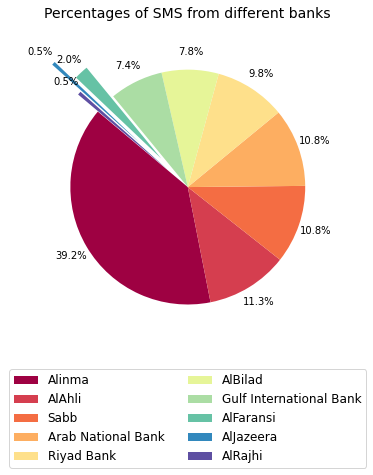

In [63]:
#Save CSV after modicifactions to data analysis
bankSet = ['Alinma','AlAhli', 'Sabb', 'Arab National Bank', 'Riyad Bank', 'AlBilad', 'Gulf International Bank', 'AlFaransi',
          'AlJazeera', 'AlRajhi']

explode = [0, 0, 0, 0, 0, 0, 0, 0.3, 0.5, 0.2]
fig = plt.figure()
plt.figure(figsize=(6,6))
colors =  ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd', '#5e4fa2']

transactions.iloc[:,0].value_counts().plot.pie(labels = None ,startangle=140, autopct='%.1f%%',pctdistance=1.15,
                                                  rotatelabels=180, colors = colors, radius=0.9, explode=explode)

 
plt.title("Percentages of SMS from different banks", fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.04), ncol=2, labels=bankSet, fontsize=12)
plt.ylabel(" ")
plt.show()


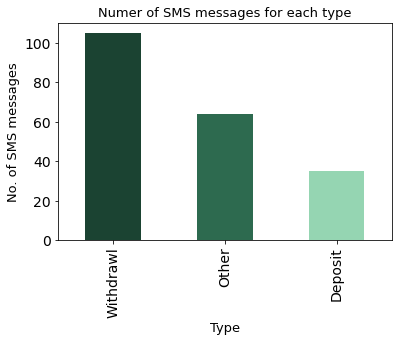

In [64]:
#Number of SMS messeges per type as bar chart
transactions["type"].value_counts().plot(kind="bar", color=["#1B4332","#2D6A4F","#95D5B2"], fontsize = 14)
plt.title("Numer of SMS messages for each type", fontsize=13)

plt.xlabel("Type",fontsize=13)
plt.ylabel("No. of SMS messages", fontsize=13)

plt.show()

In [65]:
#Number of messages per bank and its different types 
newtransactions = pd.read_csv("newtransactions.csv", index_col=False)
banknames = ['AlAhli','Sabb', 'Gulf International bank', 'Arab National Bank', 'Alfransi', 
             'Riyad bank', 'Alinma','AlJazeera','Albilad','AlRajhi']

from tabulate import tabulate
x1 = 4
y1 = 10
Matrix = [[0 for x in range(x1)] for y in range(y1)] 
#Y then X [Y,X]
c = 0
for i in range(y1):
    for j in range(x1):
        
        Matrix [i][c] = banknames [i]
        Matrix [i][c+1] = newtransactions[(newtransactions.type == 'Deposit') & (newtransactions.bankname == (banknames[i]))].shape[0]
        Matrix [i][c+2] = newtransactions[(newtransactions.type == 'Withdrawl') & (newtransactions.bankname == (banknames[i]))].shape[0]
        Matrix [i][c+3] = newtransactions[(newtransactions.type == 'Other') & (newtransactions.bankname == (banknames[i]))].shape[0]
    

print (tabulate(Matrix, headers=["Bank name", "Deposit", "Withdrawal", "Other"]))
 


Bank name                  Deposit    Withdrawal    Other
-----------------------  ---------  ------------  -------
AlAhli                           5             6       12
Sabb                             6             9        7
Gulf International bank          1             8        6
Arab National Bank               1            19        2
Alfransi                         2             1        1
Riyad bank                       5             8        7
Alinma                          12            49       19
AlJazeera                        0             0        1
Albilad                          3             5        8
AlRajhi                          0             0        1


# Preprocessing


Steps involved in this section:

* Detecting and dealing with missing values 
* Change all the text to lower case
* Removing any arabic words that appeard in the SMS messages
* Word Tokenization
* Remove stop words
* Remove Non-alpha text

In [66]:
#rename ï»¿ with blank in every column name
transactions.columns = transactions.columns.str.replace('ï»¿', '')

#view updated list of column names
list(transactions)

['bankname', 'type', 'sms']

In [67]:
#Drop any null value in SMS column
missing_value = pd.DataFrame(transactions.isna().sum().sort_values(ascending=False),columns=['No.records'])
missing_value['percentage']=(transactions.isna().sum()/len(transactions))*100
transactions['sms'].dropna(inplace=True)

In [68]:
#lower all sms messages to avoid upper-lower case sensitiviy
transactions['sms'] = [entry.lower() for entry in transactions['sms']]

In [69]:
#this method to keep only English letters + numbers
def remove_arabic(msg):
    arr_msg = msg.split(' ');
    regexPattern = "^[A-Za-z0-9]+";
    english_arr_msg = [ i for i in arr_msg if re.search(regexPattern,i) and i != '']
    space = " "
    return space.join(english_arr_msg)

In [70]:
#remove_arabic
transactions['sms'] = [remove_arabic(entry) for entry in transactions['sms']]

#test message before tokenize it & all arabic text removed 
print(transactions['sms'][10])

outgoing fund transfer approved
from: sar 76.29
beneficiary name: iban: bank: 05-08-2022 21:46:04
reference id: 2240434872
transaction id: sd6775406


In [71]:
#tokenizedWords = np.empty(204, dtype = str)
tokenizer = RegexpTokenizer("[\w+|\$[\d\.]+|\S+]+")        
transactions['sms']= [tokenizer.tokenize(entry) for entry in transactions['sms']]

In [72]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.

for index,entry in enumerate(transactions['sms']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            Final_words.append(word)
    # The final processed set of words for each iteration will be stored in 'sms_final'
    transactions.loc[index,'sms_final'] = str(Final_words)


[nltk_data] Downloading package wordnet to /Users/hailah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/hailah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hailah/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hailah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
#Test a row with preprocessing
print(transactions['sms'][10])

['outgoing', 'fund', 'transfer', 'approved', 'from', 'sar', '76.29', 'beneficiary', 'name', 'iban', 'bank', '05', '08', '2022', '21', '46', '04', 'reference', 'id', '2240434872', 'transaction', 'id', 'sd6775406']


# Model Building

###### 1- Splitting the dataset for Train/Test 80/20

In [74]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(
    transactions[['sms_final','bankname']],transactions['type'],test_size=0.2)

###### 2- Encoding

In [75]:
#0 => deposit , 1=>others , 2=> withdrawls
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

###### 3- Word Vectorization

In [76]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(transactions['sms_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X['sms_final'])
Test_X_Tfidf = Tfidf_vect.transform(Test_X['sms_final'])

In [77]:
print(Tfidf_vect.vocabulary_)

{'pos': 254, 'purchase': 258, 'pay': 240, 'amount': 42, 'sar': 286, 'mada': 199, 'card': 81, 'stc': 305, 'dear': 104, 'customer': 98, 'please': 251, 'update': 332, 'personal': 245, 'information': 173, 'within': 348, 'days': 103, 'avoid': 64, 'account': 2, 'kindly': 185, 'need': 222, 'visit': 343, 'sabb': 281, 'atm': 60, 'withdrawal': 347, 'riyadh': 277, 'cent': 82, 'sa': 279, 'date': 101, 'aldrees': 25, 'type': 329, 'apple': 47, 'notification': 226, 'online': 232, 'banking': 68, 'service': 293, 'status': 304, 'blocked': 75, 'incorrect': 172, 'password': 239, 'attempts': 61, 'action': 4, 'use': 336, 'forget': 142, 'steps': 306, 'meem': 207, 'app': 46, 'unblock': 330, 'services': 294, 'call': 80, 'contact': 92, 'center': 83, 'location': 192, 'due': 116, 'scheduled': 291, 'systems': 315, 'updates': 334, 'telemoney': 318, 'available': 63, 'anb': 43, 'net': 223, 'mobile': 210, 'saturday': 289, 'appreciate': 49, 'number': 228, 'international': 178, 'portugal': 253, 'fees': 138, 'logged': 193

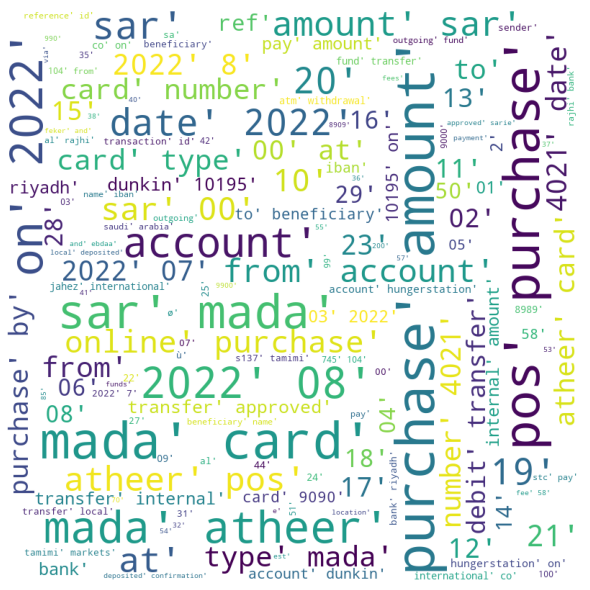

In [78]:
comment_words = ''
stopwords = set(STOPWORDS)

sms = transactions[transactions['type'] == "Withdrawl"]['sms']


# iterate through the csv file
for val in sms:
    val = str(val)


    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()


    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

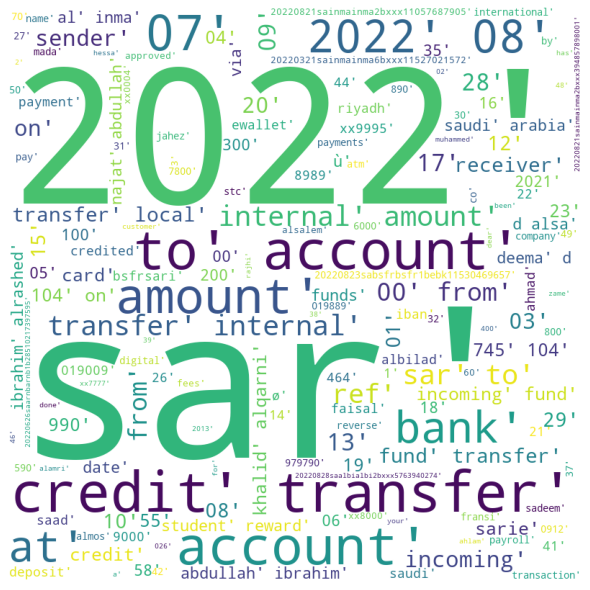

In [79]:
comment_words = ''
stopwords = set(STOPWORDS)

sms = transactions[transactions['type'] == "Deposit"]['sms']

# iterate through the csv file
for val in sms:
    val = str(val)

    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


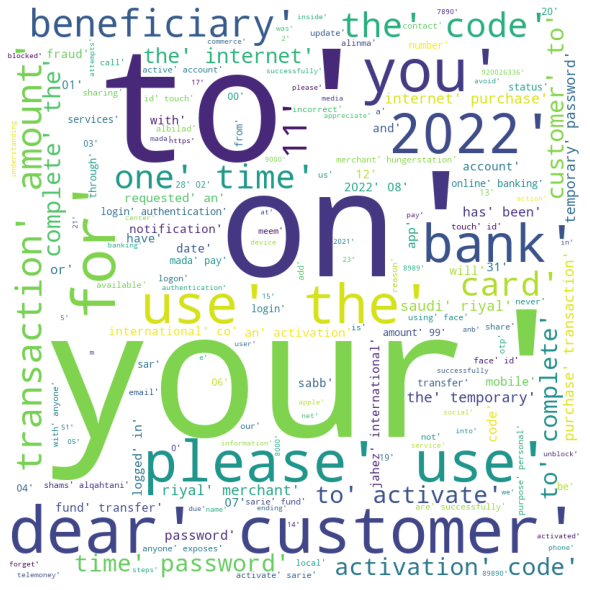

In [80]:
comment_words = ''
stopwords = set(STOPWORDS)

sms = transactions[transactions['type'] == "Other"]['sms']

# iterate through the csv file
for val in sms:
    val = str(val)


    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()


    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

###### 4- Use SVM & Naieve Bayes to predict the outcome

###### (Use grid serach in SVM to get the best parameter)

In [81]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='rbf', gamma=0.1, C=10)
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  90.2439024390244


In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['linear', 'poly', 'rbf']}

grid = GridSearchCV(SVM,param_grid,refit=True,verbose=3)

grid.fit(Train_X_Tfidf,Train_Y)

print ("Best parameters: ")
print (grid.best_params_) #Best values 

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.545 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.576 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.515 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.594 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.594 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.515 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.515 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.515 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.531 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.500 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

[CV 4/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.844 total time=   0.0s
[CV 5/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.938 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.515 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.515 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.515 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.531 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.500 total time=   0.0s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.515 total time=   0.0s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.515 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.515 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.531 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END ...C=1, gamma=0

[CV 4/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.531 total time=   0.0s
[CV 5/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END .....C=100, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 2/5] END .....C=100, gamma=1, kernel=linear;, score=0.970 total time=   0.0s
[CV 3/5] END .....C=100, gamma=1, kernel=linear;, score=0.970 total time=   0.0s
[CV 4/5] END .....C=100, gamma=1, kernel=linear;, score=0.844 total time=   0.0s
[CV 5/5] END .....C=100, gamma=1, kernel=linear;, score=0.969 total time=   0.0s
[CV 1/5] END .......C=100, gamma=1, kernel=poly;, score=0.758 total time=   0.0s
[CV 2/5] END .......C=100, gamma=1, kernel=poly;, score=0.788 total time=   0.0s
[CV 3/5] END .......C=100, gamma=1, kernel=poly;, score=0.848 total time=   0.0s
[CV 4/5] END .......C=100, gamma=1, kernel=poly;, score=0.719 total time=   0.0s
[CV 5/5] END .......C=100, gamma=1, kernel=poly;, score=0.875 total time=   0.0s
[CV 1/5] END ........C=100, 

[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.970 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.970 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.969 total time=   0.0s
[CV 1/5] END C=1000, gamma=0.001, kernel=linear;, score=1.000 total time=   0.0s
[CV 2/5] END C=1000, gamma=0.001, kernel=linear;, score=0.970 total time=   0.0s
[CV 3/5] END C=1000, gamma=0.001, kernel=linear;, score=0.970 total time=   0.0s
[CV 4/5] END C=1000, gamma=0.001, kernel=linear;, score=0.844 total time=   0.0s
[CV 5/5] END C=1000, gamma=0.001, kernel=linear;, score=0.969 total time=   0.0s
[CV 1/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.515 total time=   0.0s
[CV 2/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.515 total time=   0.0s
[CV 3/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.515 total time=   0.0s
[CV 4/5] END ..C=1000, gamma

In [83]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  87.8048780487805


# Evaluation metrics

### SVM

TN - True Negative 2
FP - False Positive 0
FN - False Negative 0
TP - True Positive 15
Accuracy Rate: 0.4146341463414634
Misclassification Rate: 0.0


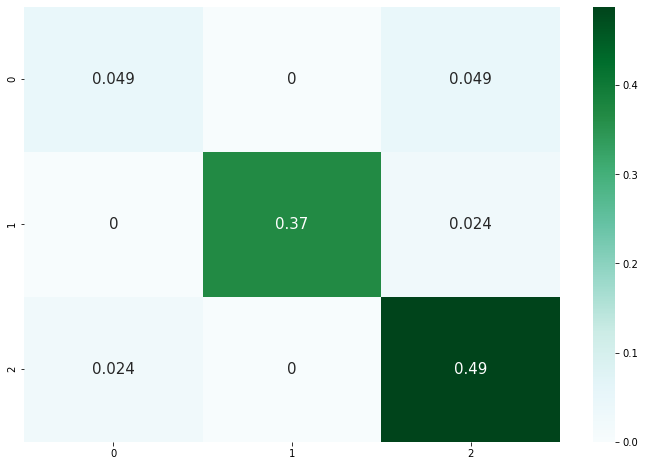

In [84]:
# confusion matrix Train_X, Test_X, Train_Y, Test_Y
cf_matrix = confusion_matrix(Test_Y.tolist(), predictions_SVM.tolist())
plt.subplots(figsize=(12,8))
_= sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = "BuGn", annot = True, annot_kws = {'size':15})
print('TN - True Negative {}'.format(cf_matrix[0,0]))
print('FP - False Positive {}'.format(cf_matrix[0,1]))
print('FN - False Negative {}'.format(cf_matrix[1,0]))
print('TP - True Positive {}'.format(cf_matrix[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cf_matrix[0,0],cf_matrix[1,1]]),np.sum(cf_matrix))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cf_matrix[0,1],cf_matrix[1,0]]),np.sum(cf_matrix))))

In [85]:
print(classification_report(Test_Y, predictions_SVM))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       1.00      0.94      0.97        16
           2       0.87      0.95      0.91        21

    accuracy                           0.90        41
   macro avg       0.85      0.80      0.82        41
weighted avg       0.90      0.90      0.90        41



### NB

TN - True Negative 2
FP - False Positive 0
FN - False Negative 0
TP - True Positive 14
Accuracy Rate: 0.3902439024390244
Misclassification Rate: 0.0


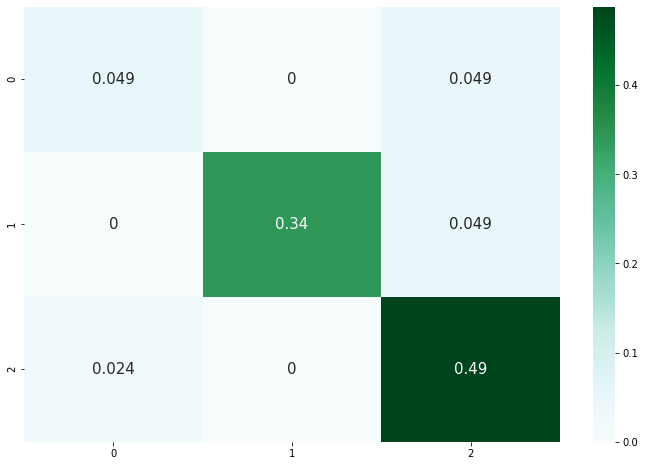

In [86]:
# confusion matrix Train_X, Test_X, Train_Y, Test_Y
cf_matrix = confusion_matrix(Test_Y.tolist(), predictions_NB.tolist())
plt.subplots(figsize=(12,8))
_= sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = "BuGn", annot = True, annot_kws = {'size':15})
print('TN - True Negative {}'.format(cf_matrix[0,0]))
print('FP - False Positive {}'.format(cf_matrix[0,1]))
print('FN - False Negative {}'.format(cf_matrix[1,0]))
print('TP - True Positive {}'.format(cf_matrix[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cf_matrix[0,0],cf_matrix[1,1]]),np.sum(cf_matrix))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cf_matrix[0,1],cf_matrix[1,0]]),np.sum(cf_matrix))))


In [87]:
print(classification_report(Test_Y, predictions_NB))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       1.00      0.88      0.93        16
           2       0.83      0.95      0.89        21

    accuracy                           0.88        41
   macro avg       0.83      0.78      0.80        41
weighted avg       0.88      0.88      0.88        41



# Look into the reason for the misclassification

In [88]:
data = {'Bank': Test_X['bankname'],
 'Actual': Test_Y ,
'Predicted': predictions_SVM }

In [89]:
df_scatter_plot = pd.DataFrame(data)

In [90]:
#cheking if the values is matched
df_scatter_plot["is_matched"] = df_scatter_plot["Actual"] == df_scatter_plot["Predicted"]

In [91]:
df_scatter_plot['Type'] = df_scatter_plot['Actual'].replace([0,1,2],['Deposit','Others','Withdrawls'])

In [92]:
#count the number of matched records using (sum)  ****FOR EVERY BANK!***
df_grouped_ = df_scatter_plot.groupby('Bank')['is_matched'].agg(['sum','count']).reset_index()

#subtracting all (count) from matched (sum) to get mismatched
df_grouped_["miss_matched"] = abs(df_grouped_['sum'] - df_grouped_['count'] )
#rename
df_grouped_["matched"] = df_grouped_["sum"] 
df_grouped_ = df_grouped_[["Bank","matched","miss_matched"]]
df_grouped_.sort_values('matched', ascending=False)
df_grouped_


,Bank,matched,miss_matched
0,AlAhli,6,0
1,AlJazeera,0,1
2,Albilad,6,0
3,Alinma,10,0
4,Arab National Bank,9,1
5,Riyad bank,3,0
6,Sabb,3,2


In [99]:
#count the number of matched records using (sum)  ****FOR EVERY BANK!***
df_grouped = df_scatter_plot.groupby(['Bank','Type'])['is_matched'].agg(['sum','count']).reset_index()

# #subtracting all (count) from matched (sum) to get mismatched
df_grouped["miss_matched"] = abs(df_grouped['sum'] - df_grouped['count'] )
# #rename
df_grouped["matched"] = df_grouped["sum"] 

In [100]:
df_grouped = df_grouped[["Bank","Type","matched","miss_matched"]]

In [101]:
df_grouped.sort_values('Bank', ascending=False)

,Bank,Type,matched,miss_matched
16,Sabb,Withdrawls,1,1
15,Sabb,Others,2,0
14,Sabb,Deposit,0,1
13,Riyad bank,Withdrawls,1,0
12,Riyad bank,Others,1,0
11,Riyad bank,Deposit,1,0
9,Arab National Bank,Others,1,0
10,Arab National Bank,Withdrawls,8,0
8,Arab National Bank,Deposit,0,1
7,Alinma,Withdrawls,7,0


In [96]:
def prepare_predict_msg(test_msg):
    transactions = pd.read_csv("newtransactions.csv",encoding='latin-1')
    transactions.columns = transactions.columns.str.replace('ï»¿', '')

    
    test_msg_lower = test_msg.lower()
    test_msg_lower_no_arabic =  remove_arabic(test_msg_lower)
    tokenizer = RegexpTokenizer("[\w+|\$[\d\.]+|\S+]+")
    test_msg_tokenize = tokenizer.tokenize(test_msg_lower_no_arabic) 

    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('stopwords')

    Final_words = []

    for word, tag in pos_tag(test_msg_tokenize):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            Final_words.append(word)
    # The final processed set of words for each iteration will be stored in 'sms_final'
    test_msg_tokenize_final = str(Final_words)
    
    test_msg_Tfidf = Tfidf_vect.transform([test_msg_tokenize_final])
    
    return test_msg_Tfidf

In [97]:
import pickle
pickle.dump(SVM, open('SVM_model.pkl', 'wb'))